In [119]:
import sys
sys.path.append('../../')

import pandas as pd
from python_src.figures_utils import get_all_expected, generate_experimental_df, get_relabund_files, fully_combined, generate_cb
from dataclasses import dataclass
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import os
import numpy as np
import datetime

from scipy.stats import f_oneway, kruskal, wilcoxon
from statsmodels.sandbox.stats.multicomp import multipletests
from matplotlib.legend_handler import HandlerTuple

today = datetime.date.today()
date = today.strftime("%Y-%m-%d")

# Dataclass Initialization

In [ ]:
@dataclass
class Pipeline:
    """
    This class will hold the parameters for each pipeline.
    Variables:
        root: str
            The root directory of the pipeline.
        inset: bool
            Whether or not to include an inset plot.
    """
    root: str
    inset: bool

    def __init__(self, root: str, inset: bool):
        self.root = root
        self.inset = inset

tourlousse = Pipeline("../../pipelines/tourlousse", False)
amos_hilo = Pipeline("../../pipelines/amos/hilo", False)
amos_mixed = Pipeline("../../pipelines/amos/mixed", False)

# experiments = [tourlousse, amos_hilo, amos_mixed]
experiments = [tourlousse]

In [ ]:
def fix_x_labels(ax, df, rank):
    """ Fix the x labels to be the species name rather than the TAX_ID. """
    xticks = ax.get_xticklabels()
    # print(xticks)
    new_labels = []
    for x in xticks:
        # res = df.loc[int(x.get_text()), rank]
        res = df.loc[df["TAX_ID"] == int(x.get_text()), rank]
        # Get only the first row from the series.
        # This is necessary because if it is unique, it will return a string, but if it is not unique, it will return a series.
        if isinstance(res, pd.Series):
            res = res.iloc[0]
        new_labels.append(res)

    return new_labels

In [ ]:
cb_palette = generate_cb()

def make_title(rank: str, exp_name: str, thresh: float):
    """ Makes title from rank, exp_name, and threshold. """
    return f"Average Relative Abundance of {rank.capitalize()} in Experiement {exp_name.capitalize()} at Threshold {thresh}"

def plot_bars(thresh: float, rank: str = "genus"):

    for e in experiments:
        # Initialize the dataframe to hold the data.
        plt_df = pd.DataFrame()
        # Make the bigger figure.
        # fig = plt.figure(figsize=(15, 12))

        exp_name = e.root.split("/")[-1]

        # Get the data for the experiment.
        expected_root = e.root.replace("pipelines", "expected_pipelines")
        fc = fully_combined(root_dir=e.root, expected_root=expected_root, rank=rank)

        # Only select where Source is "expected", "bio4", or "jams202212".
        fc = fc.loc[fc["Source"].isin(["Expected", "biobakery4", "jams202212"])]
        # fc.to_csv(f"{rank}_{exp_name}_fc.csv", index=True)

        continue
        
        """        
        for pl, pl_df in fc.groupby("Source"):
            # Average the abundances on the same index values. This keeps the names of the taxa.
            averaged_df = pl_df.groupby(["TAX_ID", rank, "Source"]).mean(numeric_only=True)

            # Filter out the values that are below the threshold.
            averaged_df = averaged_df.loc[averaged_df["RA"] > thresh]

            # Add the data to the plot dataframe.
            plt_df = pd.concat([plt_df, averaged_df], axis=0)

            # pl_df.to_csv(f"genus_{pl}.csv", index=True)

        plt_df.reset_index(inplace=True)        

        # We want only bio4 and jams.
        plt_df = plt_df.loc[plt_df["Source"].isin(["Expected", "bio4", "jams"])]

        # Plot the data.
        ax = sns.barplot(x="TAX_ID", y='RA', hue="Source", data=plt_df, errorbar=None, log=True, palette=cb_palette)
        ax.set_xticklabels(fix_x_labels(ax=ax, df=plt_df, rank=rank), rotation=45, horizontalalignment='right')

        # Make the title and add the axes labels.
        ax.set_title(make_title(rank, exp_name, thresh))
        ax.set_xlabel(rank.capitalize())
        ax.set_ylabel('Average Relative Abundance')

        # Save the plt_df.
        # plt_df.to_csv(f"{rank}_{exp_name}_{thresh}.csv", index=False)
        """

plot_bars(0.0001, "species")
plot_bars(0.0001, "genus")

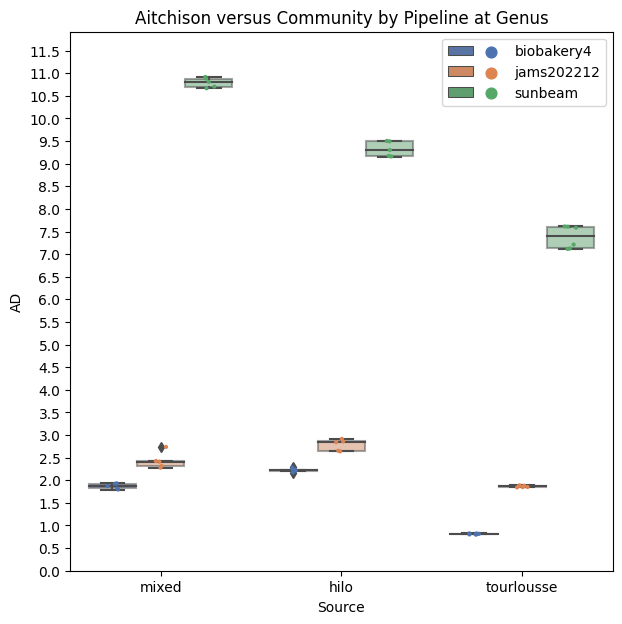

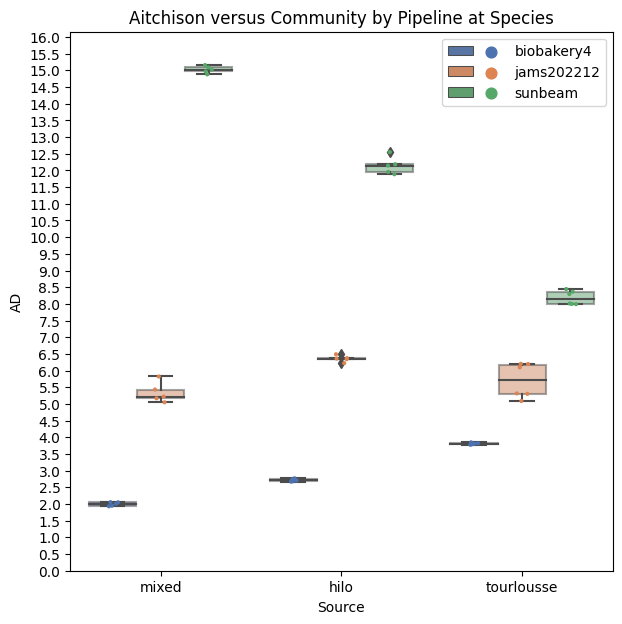

In [126]:
# Creation of Statistical Analysis Plots
stats_path_genus = os.path.abspath(f"../../utils/analysis/results/all_stats_genus.csv")
stats_path_species = os.path.abspath(f"../../utils/analysis/results/all_stats_species.csv")
stats_paths = [stats_path_genus, stats_path_species]

def decorate_plot(g: plt.Axes, df: pd.DataFrame, rank: str):
    g.set(ylim=(0, df["AD"].max() + 1))
    g.set(title=f"Aitchison versus Community by Pipeline at {rank.capitalize()}")
    g.set(yticks=np.arange(0, df["AD"].max() + 1, 0.5))


def non_avg_stats(threshold: float, stats_paths: list):
    for stats_path in stats_paths:
        rank = stats_path.split("/")[-1].split("_")[2].split(".")[0]
        stats_df = pd.DataFrame()

        # print(stats_path)
        df = pd.read_csv(stats_path)
        df = df.loc[(df["Source"] == "tourlousse") | (df["Source"] == "mixed") | (df["Source"] == "hilo")]
        df = df.loc[(df["Pipeline"] == "biobakery4") | (df["Pipeline"] == "jams202212") | (df["Pipeline"] == "sunbeam")]
        df = df.loc[(df["threshold"] == threshold)]

        fig = plt.figure(figsize=(7,7))
        g = sns.boxplot(x="Source", y="AD", hue="Pipeline", data=df, palette="deep", dodge=True, boxprops={'alpha': 0.5})
        sns.stripplot(x="Source", y="AD", hue="Pipeline", data=df, palette="deep", dodge=True, size=3, linewidth=0)

        decorate_plot(g, df, rank)

        handles, labels = g.get_legend_handles_labels()
        g.legend(handles=[(handles[0], handles[3]), (handles[1], handles[4]), (handles[2], handles[5])],
          labels=['biobakery4', 'jams202212', 'sunbeam'],
          loc='upper right', handlelength=4,
          handler_map={tuple: HandlerTuple(ndivide=None)})
        
        # Set y-axis limit from 0 to max AD + 1.
        
        # pairs = list(combinations(df["Pipeline"].unique(), 2))
        hue_order = ["biobakery4", "jams202212", "sunbeam"]
        src_order = ["mixed", "hilo", "tourlousse"]

        pairs = []
        # for h in hue_order: 
        #     for src in src_order:
        #         pairs.append((src, h))

        # print(pairs)

        # ann = Annotator(g, data=df, pairs=pairs, x="Source", y="AD", hue="Pipeline")
        # ann.configure(test="Wilcoxon", text_format='star', loc='inside')
        # ann.apply_and_annotate()

        # Save the plot.
        plt.savefig(f"{rank}_box.png", dpi=300)

        plt.show()

        for src, src_df in df.groupby("Source"):
            for pl, pl_df in src_df.groupby("Pipeline"):
                # pl_df.loc["Average"] = pl_df.mean(numeric_only=True)
                avg = pl_df.mean(numeric_only=True)
                std = pl_df.std(numeric_only=True)

                avg_cols = avg.keys()
                avg_cols = ["Pipeline", "Community"] + avg_cols.to_list()

                new_line = [f"{val:.2f} \u00b1 {std[c]:.2f}" for c, val in enumerate(avg)]
                new_line.insert(0, src)
                new_line.insert(0, pl)
                # print(new_line)
                stats_df = pd.concat([stats_df, pd.DataFrame(new_line, index=avg_cols).T])

                # stats_df = pd.concat([stats_df, avg])
                # stats_df = pd.concat([stats_df, std])
                # pl_df.loc["Stddev"] = pl_df.std(numeric_only=True)
                # pl_df.loc["Stddev"] = pl_df.std(numeric_only=True)
                # display(pl_df)
        # display(stats_df)
        stats_df.to_csv(f"{rank}_stats.csv", index=False, encoding="cp1252")
    
non_avg_stats(0.0001, stats_paths=stats_paths)

# Stochastic Replacement Averaging
If multiple runs are conducted to "average out" the replacement method, you can run the below code. This is not really being used.

In [ ]:
species_subset = "../../utils/analysis/all_stats_species_subset.csv"
genus_subset = "../../utils/analysis/all_stats_genus_subset.csv"
data_subset = [species_subset, genus_subset]

cols = ["SampleID", "Diversity", "R^2", "MAE", "AD", "1-BC", "RMSE", "Sens", "FPRA", "Pipeline", "threshold", "Source", "Run"]


def average_jams_runs():
    for data_path in data_subset:
        stats_df_avg = pd.DataFrame()
        df = pd.read_csv(data_path, names=cols)
        for src, src_df in df.groupby("Source"):
            pl_avg = src_df.groupby("Pipeline").mean(numeric_only=True)
            pl_std = src_df.groupby("Pipeline").std(numeric_only=True)

            # Items in the same index should be of the format "val ± std"
            pl_avg = pl_avg[["R^2", "AD", "Sens", "FPRA"]]
            pl_std = pl_std[["R^2", "AD", "Sens", "FPRA"]]
            for c, col in enumerate(pl_avg.columns):
                pl_avg[col] = [f"{float(val):.2f} ± {float(pl_std[col][c]):.2f}" for c, val in enumerate(pl_avg[col])]
                pl_avg["Source"] = src
            
            stats_df_avg = pd.concat([stats_df_avg, pl_avg])

        if "genus" in data_path:
            stats_df_avg.to_csv("genus_stats_mr.csv", index=True)
        elif "species" in data_path:
            stats_df_avg.to_csv("species_stats_mr.csv", index=True)
        else:
            raise Exception("Invalid data path")
        display(stats_df_avg)


            # display(pd.DataFrame(pl_avg))
            # display(pd.DataFrame(pl_std))
            # for pl, pl_df in src_df.groupby("Pipeline"):
            #     display(pl_df)
            #     avg = pl_df.groupby("SampleID").mean(numeric_only=True)
            #     display(pd.DataFrame(avg))
                # for smpl, smpl_df in pl_df.groupby("SampleID"):
                #     avg = smpl_df.mean(numeric_only=True)
                #     new_row = pd.DataFrame(avg).T
                #     new_row["SampleID"] = smpl
                #     new_row["Pipeline"] = pl
                #     new_row["Source"] = src
                #     display(new_row)

        # display(df)

# average_jams_runs()